In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image

# Set up Arguments

In [14]:
batch_size = 128
data_dimensions = 784
epochs = 10
no_cuda = False
seed = 1
beta = 1
log_interval = 100
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 12, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 20
lambda_od = 10
lambda_d = 10*lambda_od
explore = True
file_output = 'results/latent_' + str(loss_function_type) + '_beta_' + str(beta) + '_latentdim_' + str(latent_dimensions) + '_lambdaod_' + str(lambda_od) + '_lambdad_' + str(lambda_d) +'.png'
print(file_output)

results/latent_Beta_beta_1_latentdim_20_lambdaod_10_lambdad_100.png


In [3]:
# seed 
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")
# data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)


In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(data_dimensions, 400)
        self.mu_i = nn.Linear(400, latent_dimensions)
        self.var_i = nn.Linear(400, latent_dimensions)
        self.fc3 = nn.Linear(latent_dimensions, 400)
        self.fc4 = nn.Linear(400, data_dimensions)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.mu_i(h1), self.var_i(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
class convolutionalVAE(nn.Module):
    def __init__(self):
        super(convolutionalVAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.mu_i = nn.Linear(8000, latent_dimensions)
        self.var_i = nn.Linear(8000, latent_dimensions)
        
        self.deconv1 = nn.ConvTranspose2d(8000, 100, kernel_size=10)
        self.deconv2 = nn.ConvTranspose2d(100, 20, kernel_size=10)
        self.deconv3 = nn.ConvTranspose2d(20, 1, kernel_size=10)
        #self.deconv4 = nn.ConvTranspose2d(10, 1, kernel_size=11)
        
        self.fc = nn.Linear(20, 8000)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        #set_trace()
        return self.mu_i(x), self.var_i(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = F.relu(self.fc(z))
        # 8000 is 20*20*20
        z = z.view(z.size(0), 8000, 1, 1)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = torch.sigmoid(self.deconv3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = convolutionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    if loss_function_type == 'DIP-VAE1':
        return DIP_1_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'DIP-VAE2':
        return DIP_2_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'Beta':
        return beta_loss_function(recon_x, x, mu, logvar)

def beta_loss_function(recon_x, x, mu, logvar):
    # TOFIX: change x.view to just x 
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD
    

def DIP_1_loss_function(recon_x, x, mu, logvar):
    exp_mu = mu.mean(0)
    # should this mu be on the 0th or 1st axis?
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    cov = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    # diag = diagonal matrix returned, diag_part just the diagonal (diagonal)
    diag_part = torch.diagonal(cov) 
    off_diag_part = cov - torch.diag(diag_part)

    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)


def DIP_2_loss_function(recon_x, x, mu, logvar):
    sigma = torch.diag(logvar)
    exp_cov = sigma.mean(0)
    
    exp_mu = mu.mean(0)
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    
    cov_exp = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    cov_z = cov_exp + exp_cov
    
    diag_part = torch.diagonal(cov_z)
    off_diag_part = cov_z - torch.diag(diag_part)
    
    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                       recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

In [7]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dimensions).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                  'results/epoch_' + epoch + '_sample_' + str(epoch) + '.png')

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [0/60000 (0%)]	Loss: 542.062561
Train Epoch: 1 [12800/60000 (21%)]	Loss: 208.617798
Train Epoch: 1 [25600/60000 (43%)]	Loss: 204.770096
Train Epoch: 1 [38400/60000 (64%)]	Loss: 157.357666
Train Epoch: 1 [51200/60000 (85%)]	Loss: 141.426651
====> Epoch: 1 Average loss: 189.3423


/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([96, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> Test set loss: 135.6058


/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 2 [0/60000 (0%)]	Loss: 129.451309
Train Epoch: 2 [12800/60000 (21%)]	Loss: 122.607437
Train Epoch: 2 [25600/60000 (43%)]	Loss: 117.944839
Train Epoch: 2 [38400/60000 (64%)]	Loss: 109.170227
Train Epoch: 2 [51200/60000 (85%)]	Loss: 111.278465
====> Epoch: 2 Average loss: 118.0541
====> Test set loss: 113.6691
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.477295
Train Epoch: 3 [12800/60000 (21%)]	Loss: 112.229523
Train Epoch: 3 [25600/60000 (43%)]	Loss: 109.312927
Train Epoch: 3 [38400/60000 (64%)]	Loss: 102.553963
Train Epoch: 3 [51200/60000 (85%)]	Loss: 106.166397
====> Epoch: 3 Average loss: 108.5506
====> Test set loss: 106.9392
Train Epoch: 4 [0/60000 (0%)]	Loss: 104.918381
Train Epoch: 4 [12800/60000 (21%)]	Loss: 106.650352
Train Epoch: 4 [25600/60000 (43%)]	Loss: 106.000320
Train Epoch: 4 [38400/60000 (64%)]	Loss: 100.333076
Train Epoch: 4 [51200/60000 (85%)]	Loss: 103.513412
====> Epoch: 4 Average loss: 105.3658
====> Test set loss: 105.2736
Train Epoch: 5 [0/60000 (0%)]	L

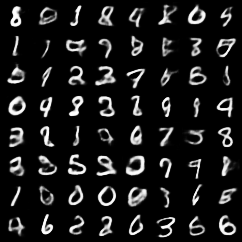

In [13]:
with torch.no_grad():
        sample = torch.randn(64, latent_dimensions).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                  'results/random_sample_test.png')
Image(filename='results/raondom_sample_test.png') 

In [10]:
batch = next(iter(train_loader))


In [17]:

if explore == True:
    data = batch[0][0:10]
    data = data.to(device)

    latent_tests = []

    # add or subtract noise to z to change it around. 
    with torch.no_grad():

        for i in range(1):
            if type(latent_tests) == list:
                latent_tests = data[i].view(1, 1, 28, 28)
            else:
                latent_tests = torch.cat((latent_tests, data[i].view(1, 1, 28, 28)), 0)
            # to let it run dont change view
            #mu, logvar = model.encode(data[i].view(-1, 784))
            mu, logvar = model.encode(data[i].view(1, 1, 28, 28))


            z = model.reparameterize(mu, logvar)
            latent_spaces = torch.from_numpy(np.arange(-3, 3, 0.29))
            latent_spaces = range(-10, 11)
            latent_space_len = len(latent_spaces)
            #print(latent_spaces)

            for j in range(latent_dimensions):
                for k in range(21):
                    temp_z = z.clone()
                    #samp = torch.randn(1, latent_dimensions)
                    #samp = samp.to(device)
                    #set_trace()
                    #print(temp_z[j].size())
                    temp_z[0][j] = latent_spaces[k]
                    x = model.decode(temp_z)
                    x = x.view(1, 1, 28, 28)
                    latent_tests = torch.cat((latent_tests, x), 0)
                # add the actual reconstruction
                x = model.decode(z)
                latent_tests = torch.cat((latent_tests, x.view(1, 1, 28, 28)), 0)
                if j != latent_dimensions-1:
                     latent_tests = torch.cat((latent_tests, data[i].view(1, 1, 28, 28)), 0)

        save_image(latent_tests.view(((latent_space_len) + 1 + 1)*latent_dimensions, 1, 28, 28),
                      file_output, nrow=23)
    Image(filename=file_output)

    #data2 = torch.cat((data1, data), 0)
    #data2.size()



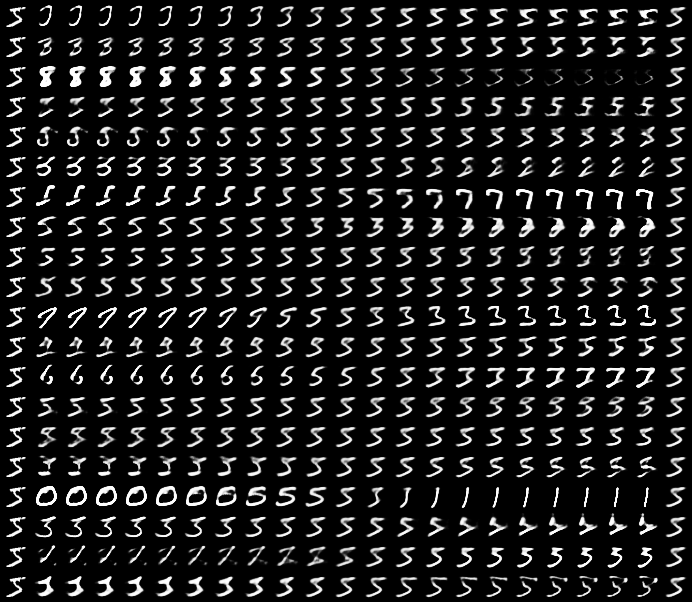

In [18]:
Image(filename=file_output)